In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

# First Model

In [2]:
df = pd.read_csv('../data/dataset.csv')

In [3]:
df.shape

(730, 12)

In [4]:
df = df['Close'].values
df = df.reshape(-1, 1)

In [5]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8):])

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

In [7]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [8]:
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [9]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [10]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

2022-03-22 20:20:23.167631: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [12]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('stock_prediction.h5')

Epoch 1/50
17/17 [==============================] - 6s 76ms/step - loss: 0.0513
Epoch 2/50
17/17 [==============================] - 1s 74ms/step - loss: 0.0138
Epoch 3/50
17/17 [==============================] - 1s 74ms/step - loss: 0.0077
Epoch 4/50
17/17 [==============================] - 1s 74ms/step - loss: 0.0084
Epoch 5/50
17/17 [==============================] - 1s 77ms/step - loss: 0.0076
Epoch 6/50
17/17 [==============================] - 1s 75ms/step - loss: 0.0072
Epoch 7/50
17/17 [==============================] - 1s 80ms/step - loss: 0.0081
Epoch 8/50
17/17 [==============================] - 1s 80ms/step - loss: 0.0073
Epoch 9/50
17/17 [==============================] - 1s 81ms/step - loss: 0.0084
Epoch 10/50
17/17 [==============================] - 1s 81ms/step - loss: 0.0068
Epoch 11/50
17/17 [==============================] - 1s 81ms/step - loss: 0.0068
Epoch 12/50
17/17 [==============================] - 1s 82ms/step - loss: 0.0059
Epoch 13/50
17/17 [==================

In [14]:
model = load_model('stock_prediction.h5')

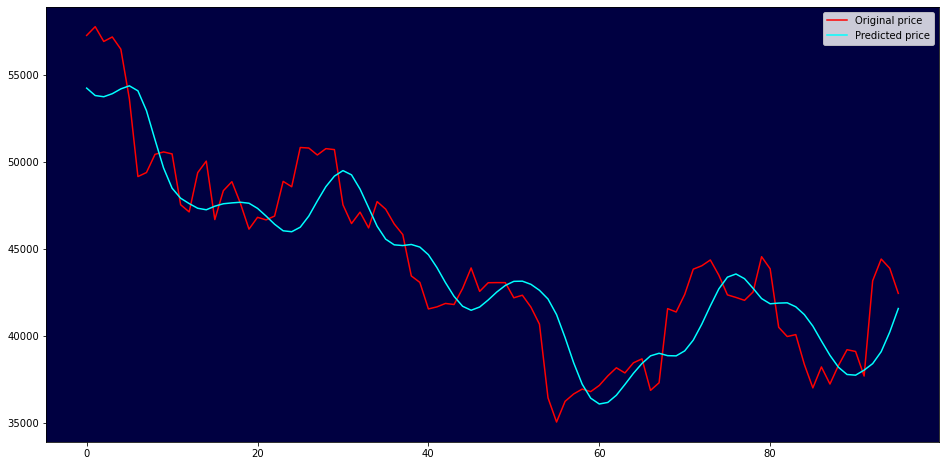

In [15]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.legend()

In [41]:
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(y_test_scaled-predictions)/y_test_scaled)).mean())

Accuracy: 95.69767208261473


# Second Model

In [16]:
df = pd.read_csv('../data/dataset.csv')
df_time = df['Time']
# df = df.drop(columns = ['Time'])
# df

<AxesSubplot:xlabel='Time'>

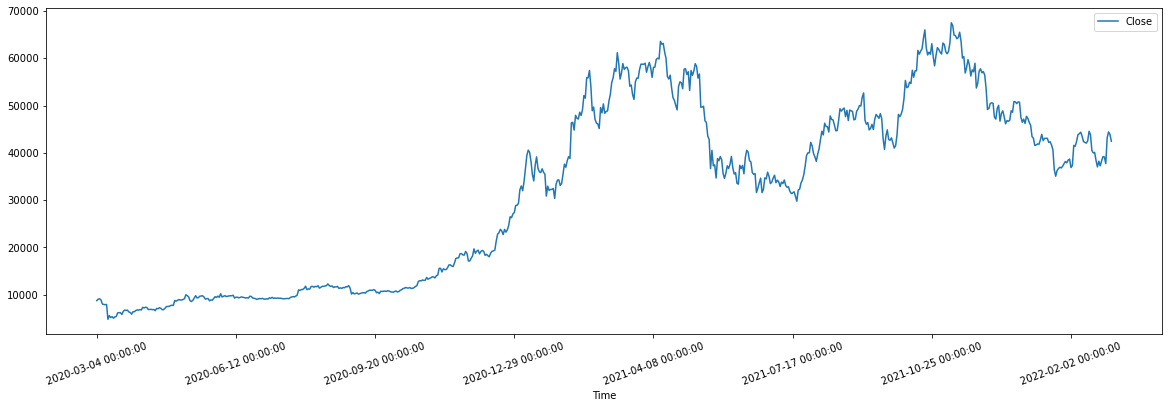

In [17]:
# Plotting the stock prices
df.plot(x='Time', y='Close', kind='line', figsize=(20,6), rot=20)

In [18]:
# Extracting the closing prices of each day
FullData=df[['Close']].values
print(FullData[0:5])
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[8750.7]
 [9056.9]
 [9134.3]
 [8889.9]
 [8036.5]]
### After Normalization ###


array([[0.06295669],
       [0.06783975],
       [0.06907407],
       [0.06517655],
       [0.05156714]])

In [19]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=5  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(725, 5, 1)

#### Output Data shape ####
(725, 1)


In [20]:
# Choosing the number of testing data records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

############################################

# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)

# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(720, 5, 1)
(720, 1)

#### Testing Data shape ####
(5, 5, 1)
(5, 1)

#### Training Data shape ####
(720, 5, 1)
(720, 1)

#### Testing Data shape ####
(5, 5, 1)
(5, 1)


In [21]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.06295669]
 [0.06783975]
 [0.06907407]
 [0.06517655]
 [0.05156714]] -- [0.04988949]
[[0.06783975]
 [0.06907407]
 [0.06517655]
 [0.05156714]
 [0.04988949]] -- [0.04931538]


In [22]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 5
Number of Features: 1


In [23]:
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
144/144 [==============================] - 2s 3ms/step - loss: 0.1551
Epoch 2/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 3/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 4/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 5/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 6/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 7/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 8/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 9/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 10/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 11/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 12/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 13/100


144/144 [==============================] - 0s 3ms/step - loss: 8.0896e-04
Epoch 99/100
144/144 [==============================] - 0s 3ms/step - loss: 8.0876e-04
Epoch 100/100
144/144 [==============================] - 0s 3ms/step - loss: 8.2534e-04
## Total Time Taken:  1 Minutes ##


Accuracy: 93.74479666650066


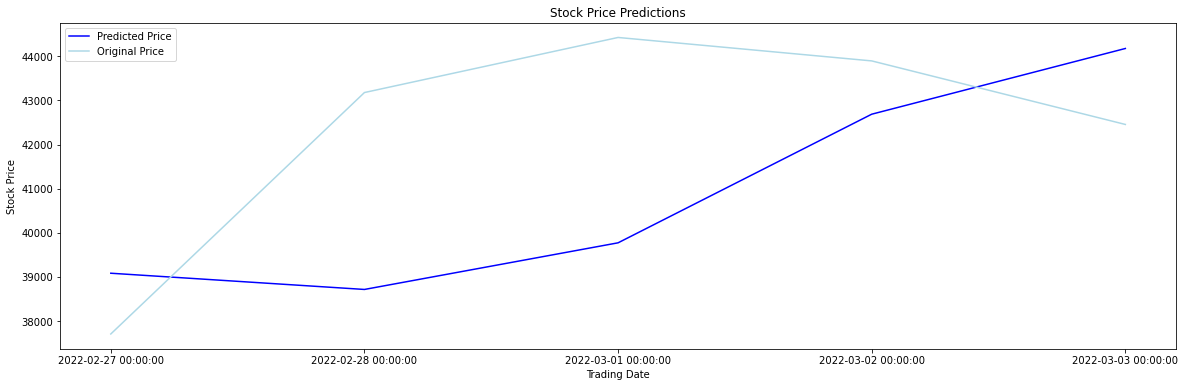

In [24]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Price')
plt.plot(orig, color = 'lightblue', label = 'Original Price')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), df.tail(TestingRecords)['Time'])
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

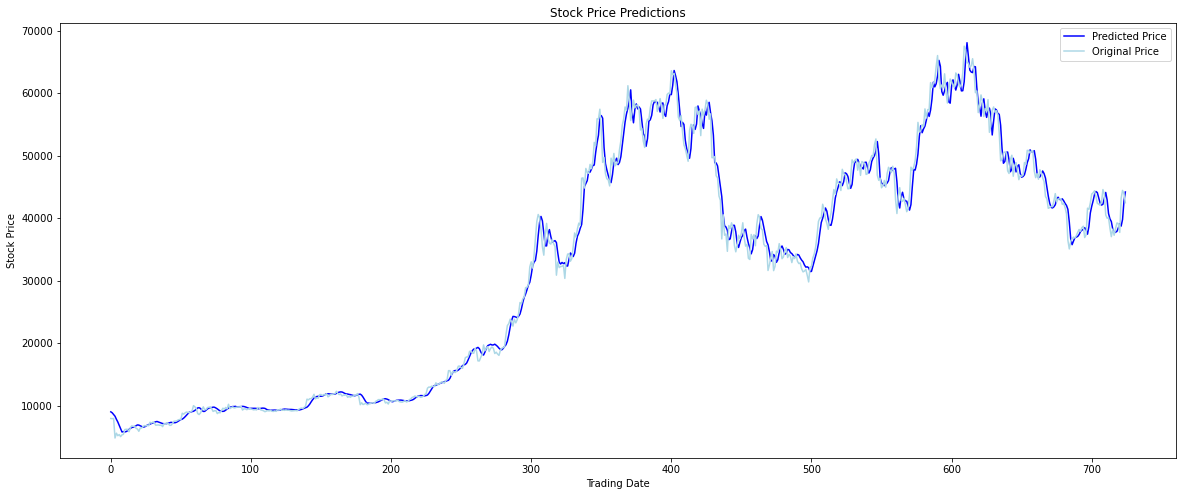

In [25]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

# Third Model

In [26]:
df = pd.read_csv('../data/dataset.csv')

In [27]:
#Print the shape of Dataframe  and Check for Null Values
print("Dataframe Shape: ", df.shape)
print("Null Value Present: ", df.isna().values.any())

Dataframe Shape:  (730, 12)
Null Value Present:  True


In [28]:
# Count missing value
print(df.isna().sum())

Time                       0
Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    2
Transactions               0
Close_mean                 1
Close_std                  2
dtype: int64


<AxesSubplot:xlabel='Time'>

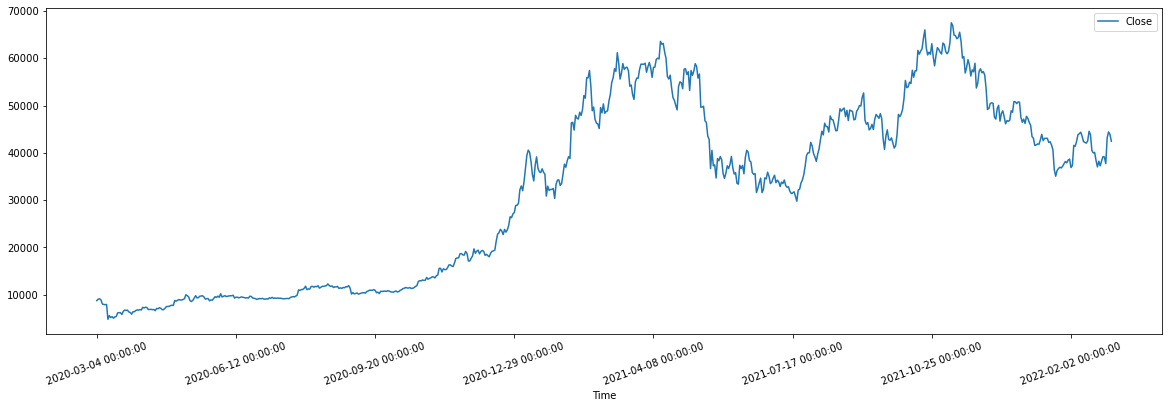

In [29]:
# Plotting the stock prices
df.plot(x='Time', y='Close', kind='line', figsize=(20,6), rot=20)

In [30]:
#Set Target Variable
output_var = pd.DataFrame(df["Close"])
#Selecting the Features
features = ["Compound", "Volume", "FundingRate", "Bitcoin_SVI", "Cryptocurrency_SVI", \
           "No. of Active Addresses", "No. of Unique Addresses", "Transactions"]
# time_var = output_var = pd.DataFrame(df["Time"])

In [31]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Compound,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions
0,0.6616,0.006956,0.406593,0.070506,0.040714,0.399875,0.429122,0.844827
1,0.6616,0.010453,0.428571,0.076814,0.034898,0.324190,0.392319,0.811569
2,0.6616,0.003008,0.439560,0.073660,0.030586,0.338011,0.388311,0.771346
3,0.6616,0.001482,0.494505,0.054838,0.027677,0.193585,0.257815,0.680871
4,0.6616,0.009495,0.516484,0.064198,0.040714,0.161141,0.213671,0.642553


In [32]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [33]:
from sklearn.impute import KNNImputer

KNN_miss_filling = KNNImputer(n_neighbors=2).fit(X_train)
X_train = pd.DataFrame(KNN_miss_filling.transform(X_train))

In [34]:
# Count missing value
print(X_train.isna().sum())

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64


In [35]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [36]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
plot_model(lstm, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [37]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
83/83 [==============================] - 1s 1ms/step - loss: 1344722048.0000
Epoch 2/100
83/83 [==============================] - 0s 1ms/step - loss: 1344643200.0000
Epoch 3/100
83/83 [==============================] - 0s 994us/step - loss: 1344460416.0000
Epoch 4/100
83/83 [==============================] - 0s 1ms/step - loss: 1344139520.0000
Epoch 5/100
83/83 [==============================] - 0s 1ms/step - loss: 1343683968.0000
Epoch 6/100
83/83 [==============================] - 0s 1ms/step - loss: 1343114112.0000
Epoch 7/100
83/83 [==============================] - 0s 997us/step - loss: 1342450560.0000
Epoch 8/100
83/83 [==============================] - 0s 974us/step - loss: 1341706240.0000
Epoch 9/100
83/83 [==============================] - 0s 973us/step - loss: 1340889600.0000
Epoch 10/100
83/83 [==============================] - 0s 976us/step - loss: 1340005120.0000
Epoch 11/100
83/83 [==============================] - 0s 979us/step - loss: 1339057152.0000
Epoch 1

83/83 [==============================] - 0s 916us/step - loss: 1137779712.0000
Epoch 91/100
83/83 [==============================] - 0s 913us/step - loss: 1134143232.0000
Epoch 92/100
83/83 [==============================] - 0s 904us/step - loss: 1130487552.0000
Epoch 93/100
83/83 [==============================] - 0s 898us/step - loss: 1126814336.0000
Epoch 94/100
83/83 [==============================] - 0s 897us/step - loss: 1123122688.0000
Epoch 95/100
83/83 [==============================] - 0s 906us/step - loss: 1119413504.0000
Epoch 96/100
83/83 [==============================] - 0s 914us/step - loss: 1115686912.0000
Epoch 97/100
83/83 [==============================] - 0s 897us/step - loss: 1111943552.0000
Epoch 98/100
83/83 [==============================] - 0s 908us/step - loss: 1108183168.0000
Epoch 99/100
83/83 [==============================] - 0s 898us/step - loss: 1104406016.0000
Epoch 100/100
83/83 [==============================] - 0s 906us/step - loss: 1100612608.0000


In [38]:
#LSTM Prediction
y_pred = lstm.predict(X_test)

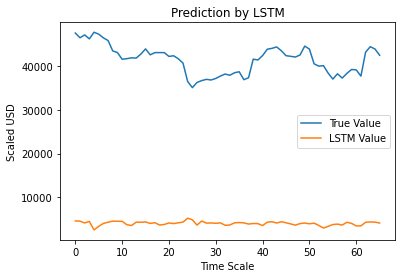

In [39]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label="True Value")
plt.plot(y_pred, label="LSTM Value")
plt.title("Prediction by LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Scaled USD")
plt.legend()
plt.show()

In [40]:
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(y_test-y_pred)/y_test)).mean())

Accuracy: 9.797959624738539
